In [42]:
import d2l

In [43]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from d2l import torch as d2l

class FashionMNIST(d2l.DataModule):
    """Fashion-MNIST数据集类"""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

    def text_labels(self, indices):
        """返回文本标签"""
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        """获取数据加载器"""
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train)

    def train_dataloader(self):
        """获取训练数据加载器"""
        return self.get_dataloader(train=True)
    
    def val_dataloader(self):
        """获取验证数据加载器"""
        return self.get_dataloader(train=False)

# 创建数据集实例
data = FashionMNIST()

# 查看数据形状
X, y = next(iter(data.train_dataloader()))
print('数据形状:', X.shape)
print('标签形状:', y.shape)

# 查看单个样本形状
print('单个样本形状:', data.train[0][0].shape)

数据形状: torch.Size([64, 1, 28, 28])
标签形状: torch.Size([64])
单个样本形状: torch.Size([1, 28, 28])


In [44]:
@d2l.add_to_class(FashionMNIST)  #@save
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

In [45]:
tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'

'6.72 sec'

In [21]:
for i in range(32):
    print(y[i])

tensor(5)
tensor(2)
tensor(7)
tensor(6)
tensor(3)
tensor(4)
tensor(2)
tensor(4)
tensor(5)
tensor(9)
tensor(9)
tensor(4)
tensor(9)
tensor(1)
tensor(3)
tensor(7)
tensor(5)
tensor(2)
tensor(8)
tensor(9)
tensor(3)
tensor(0)
tensor(8)
tensor(6)
tensor(5)
tensor(2)
tensor(4)
tensor(0)
tensor(9)
tensor(1)
tensor(6)
tensor(4)


In [22]:
@d2l.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=3, ncols=9, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

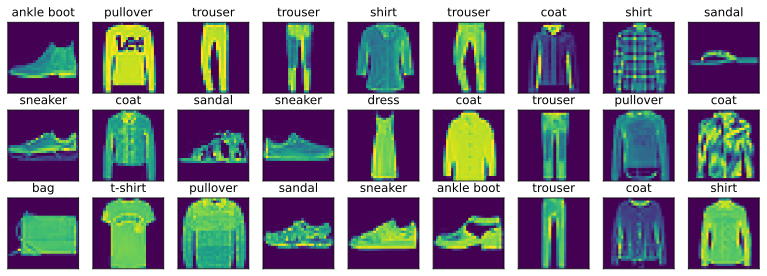

In [23]:
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

In [24]:
import torch
from d2l import torch as d2l

class Classifier(d2l.Module):  #@save
    """The base class of classification models."""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

In [25]:
@d2l.add_to_class(d2l.Module)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)

In [26]:
@d2l.add_to_class(Classifier)  #@save
def accuracy(self, Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

In [27]:
import torch
from d2l import torch as d2l
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here


In [28]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X, X.sum(1), X_prob, X_prob.sum(1)

(tensor([[0.7146, 0.3599, 0.7226, 0.6107, 0.3726],
         [0.7969, 0.3544, 0.4548, 0.4199, 0.0277]]),
 tensor([2.7804, 2.0537]),
 tensor([[0.2314, 0.1623, 0.2333, 0.2086, 0.1644],
         [0.2855, 0.1834, 0.2028, 0.1959, 0.1323]]),
 tensor([1., 1.]))

In [29]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs), requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

In [30]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

In [31]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [32]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

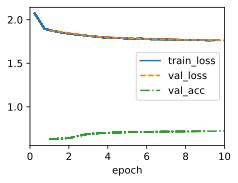

In [33]:
import torch
from d2l import torch as d2l

data = d2l.FashionMNIST(batch_size=256)
print(data.train[0][0].shape)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [35]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

torch.Size([256])

256


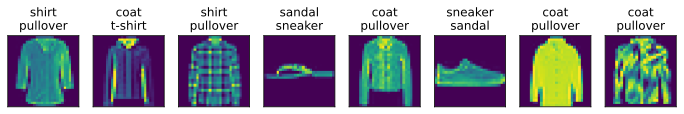

In [36]:
wrong = preds.type(y.dtype) != y
print(len(wrong))
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

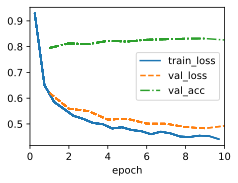

In [37]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class SoftmaxRegression(d2l.Classifier):  #@save
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))

    def forward(self, X):
        return self.net(X)

@d2l.add_to_class(d2l.Classifier)  #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(
        Y_hat, Y, reduction='mean' if averaged else 'none')

data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [38]:
data.val[0][0].shape

torch.Size([1, 28, 28])

In [39]:
print(data.val)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [40]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64


In [41]:
print(y)

tensor([1, 6, 2, 0, 3, 4, 8, 2, 2, 7, 7, 1, 6, 2, 0, 8, 7, 1, 2, 3, 1, 4, 8, 1,
        9, 4, 2, 1, 7, 9, 0, 2, 8, 3, 2, 6, 1, 1, 2, 4, 0, 5, 1, 9, 5, 4, 4, 9,
        4, 2, 6, 8, 2, 0, 0, 4, 1, 6, 1, 8, 2, 5, 3, 0, 2, 8, 6, 6, 4, 3, 5, 3,
        1, 3, 0, 0, 0, 1, 0, 9, 4, 8, 9, 8, 8, 3, 4, 6, 1, 3, 4, 8, 3, 7, 7, 2,
        4, 5, 6, 5, 9, 4, 0, 0, 9, 3, 7, 0, 4, 8, 5, 3, 2, 9, 0, 4, 7, 3, 9, 0,
        5, 8, 8, 0, 3, 4, 1, 3, 1, 6, 4, 4, 7, 4, 6, 6, 4, 0, 5, 1, 9, 2, 9, 4,
        2, 7, 7, 4, 2, 7, 7, 8, 1, 2, 6, 3, 4, 0, 1, 9, 2, 4, 6, 8, 9, 4, 6, 0,
        8, 1, 7, 2, 6, 6, 4, 5, 3, 7, 6, 9, 3, 9, 3, 1, 4, 6, 8, 0, 4, 2, 0, 4,
        0, 3, 6, 9, 6, 1, 5, 8, 1, 1, 3, 9, 6, 9, 7, 8, 0, 2, 9, 7, 8, 8, 9, 1,
        8, 8, 3, 9, 3, 9, 1, 3, 3, 2, 5, 2, 5, 2, 8, 9, 9, 5, 2, 8, 8, 5, 7, 4,
        6, 5, 8, 7, 8, 1, 9, 3, 4, 7, 4, 9, 5, 4, 3, 7])
